# Evaluate SAM1/SAM2

## ade20k sam1 sam2 comparison

In [1]:
#Code to evaluate SAM2 with 64 images from ade20k
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
from source.sam import evaluate_sam, sam12_info
from source.eval_and_plotting import (SavedSamples, DiffSamples, SavedSamplesManager)
import matplotlib.pyplot as plt
from source.utils.mixed import shaprint
import argparse
import numpy as np
import glob
import tqdm

# this prevents a weird bug with matplotlib
plt.imshow(np.random.rand(10,10))
plt.close()

### plotting 64

In [2]:
name = sam12_info["names"][0]
save_path = f"saves/sam_eval/sam12_comp/{name}_64_ade20k.pt"
sam_samples = SavedSamples()
sam_samples.load(save_path)
ssm = SavedSamplesManager(sam_samples)

(384, 603, 3)
(768, 1206, 3)
{'left': ['   Raw\n Image  ', '   Ground\n Truth  ', '   sam1_b  '], 'top': ['ade20k/27427', 'ade20k/26351', 'ade20k/27410', 'ade20k/26040'], 'xtick_kwargs': {'fontsize': 20}}


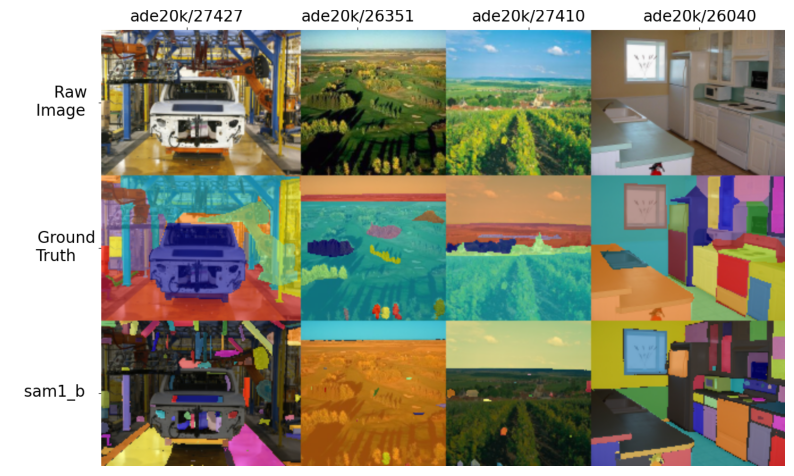

In [40]:
im = ssm.plot_qual_seg(transpose=True,add_text_axis=True,add_text_inside=True,pixel_mult=2)

fig = plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis("off");

## plotting 256

In [2]:
save_folder = f"saves/sam_eval/sam12_comp/"
ssm = SavedSamplesManager()
for save_path in glob.glob(f"{save_folder}/*"):
    if "256" in save_path:
        sam_samples = SavedSamples()
        sam_samples.load(save_path)
        print("Loaded",save_path)
        ssm.add_saved_samples(sam_samples)
ssm.sort_saved_samples(key=lambda x: sam12_info["names"].index(x.name))

Loaded saves/sam_eval/sam12_comp/sam1_b_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_s_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam1_l_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_l_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_b+_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam1_h_256_ade20k.pt
Loaded saves/sam_eval/sam12_comp/sam2_t_256_ade20k.pt


In [5]:
ssm.mean_metric_table()

sam1_b sam1_l  sam1_h  sam2_t  sam2_s sam2_b+  sam2_l
ari   0.362  0.537   0.544    0.27   0.315   0.375   0.407
hiou  0.156  0.135   0.132   0.188    0.21   0.217   0.265
iou   0.011  0.012  0.0103  0.0171  0.0259  0.0306  0.0295
mi    0.523   0.66   0.664   0.423   0.466   0.524   0.563

(445, 1152, 3)
(890, 2304, 3)
{'top': ['Raw\n Image', 'Ground\n Truth', 'sam1_b', 'sam1_l', 'sam1_h', 'sam2_t', 'sam2_s', 'sam2_b+', 'sam2_l'], 'left': ['   ade20k/27427  ', '   ade20k/26351  ', '   ade20k/27410  ', '   ade20k/26040  '], 'xtick_kwargs': {'fontsize': 20}}


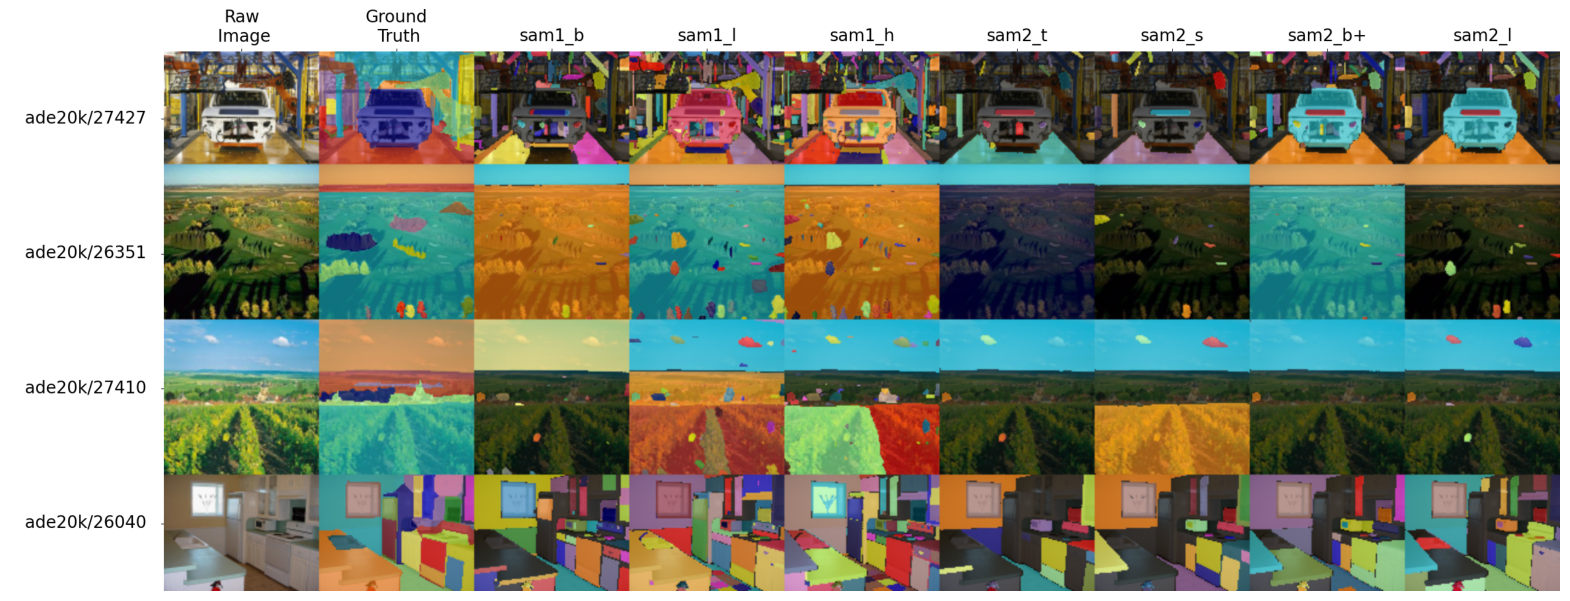

In [9]:
im = ssm.plot_qual_seg(transpose=False,add_text_axis=True,add_text_inside=False,pixel_mult=2)

fig = plt.figure(figsize=(20,20))
plt.imshow(im)
plt.axis("off");

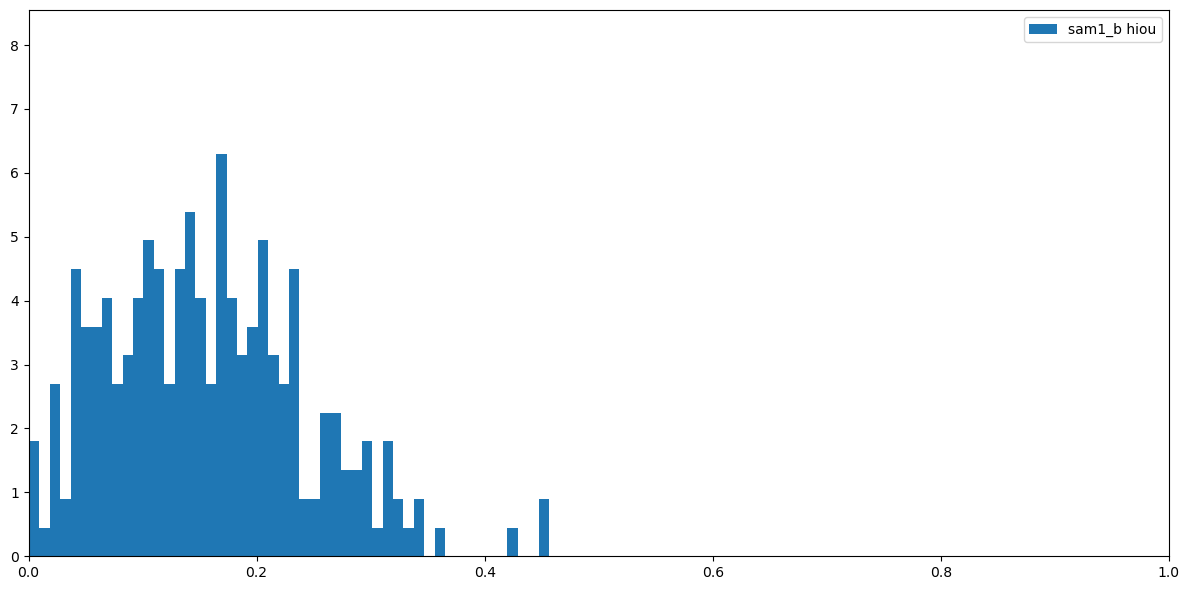

In [22]:
ssm.hist(ss_idx=[0],metric_names="hiou",bins=50)

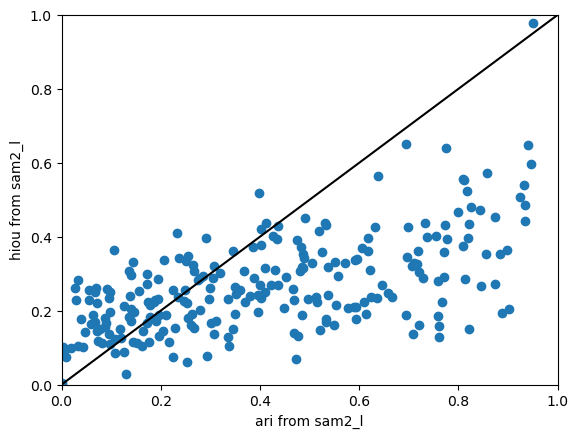

In [17]:
ssm.scatter(metric1="ari",metric2="hiou",ss_idx1=6)

## postprocessing for sam2_l

In [38]:
save_path = f"saves/sam_eval/sam12_comp/sam2_l_256_ade20k.pt"

sam_samples = SavedSamples()
sam_samples.load(save_path)
didx_w_heavy = []
for k,v in sam_samples.heavy_available.items():
    if v=="pos_loaded":
        didx_w_heavy.append(k)
print("Didx with heavy",len(didx_w_heavy))

sam_samples = sam_samples.reduce_by_indexer(didx_w_heavy)
print(len(sam_samples))

Didx with heavy 63
63


In [39]:

ssm = SavedSamplesManager(sam_samples)
min_areas = np.logspace(np.log10(0.001),np.log10(0.15),10)
for min_area in tqdm.tqdm(min_areas):
    sam_samples2 = sam_samples.clone(f"area>={min_area:.4f}")
    sam_samples2.postprocess({"mode": "min_area", "min_area": min_area})
    sam_samples2.clear_heavy_data()
    ssm.add_saved_samples(sam_samples2)
    

100%|██████████| 10/10 [08:16<00:00, 49.63s/it]


In [40]:
ssm.mean_metric_table()


sam2_l area>=0.0010 area>=0.0017 area>=0.0030 area>=0.0053 area>=0.0093  \
ari    0.398        0.402        0.402        0.401        0.399        0.394   
hiou   0.264        0.281        0.282        0.283        0.268         0.24   
iou   0.0364       0.0382       0.0385       0.0387       0.0395       0.0394   
mi     0.547        0.557        0.557        0.555         0.55         0.54   

     area>=0.0162 area>=0.0282 area>=0.0493 area>=0.0860 area>=0.1500  
ari         0.375        0.344        0.318        0.272        0.183  
hiou        0.185        0.135        0.109       0.0852       0.0565  
iou        0.0387       0.0372       0.0337       0.0312       0.0203  
mi           0.51        0.463        0.423         0.36        0.253

In [41]:
mean_metrics = ssm.mean_metric_table(to_df=False)
print(mean_metrics)

{'sam2_l': {'ari': '0.398', 'hiou': '0.264', 'iou': '0.036', 'mi': '0.547'}, 'area>=0.0010': {'ari': '0.402', 'hiou': '0.281', 'iou': '0.038', 'mi': '0.557'}, 'area>=0.0017': {'ari': '0.402', 'hiou': '0.282', 'iou': '0.038', 'mi': '0.557'}, 'area>=0.0030': {'ari': '0.401', 'hiou': '0.283', 'iou': '0.039', 'mi': '0.555'}, 'area>=0.0053': {'ari': '0.399', 'hiou': '0.268', 'iou': '0.040', 'mi': '0.550'}, 'area>=0.0093': {'ari': '0.394', 'hiou': '0.240', 'iou': '0.039', 'mi': '0.540'}, 'area>=0.0162': {'ari': '0.375', 'hiou': '0.185', 'iou': '0.039', 'mi': '0.510'}, 'area>=0.0282': {'ari': '0.344', 'hiou': '0.135', 'iou': '0.037', 'mi': '0.463'}, 'area>=0.0493': {'ari': '0.318', 'hiou': '0.109', 'iou': '0.034', 'mi': '0.423'}, 'area>=0.0860': {'ari': '0.272', 'hiou': '0.085', 'iou': '0.031', 'mi': '0.360'}, 'area>=0.1500': {'ari': '0.183', 'hiou': '0.056', 'iou': '0.020', 'mi': '0.253'}}


In [63]:
refv

'0.547'

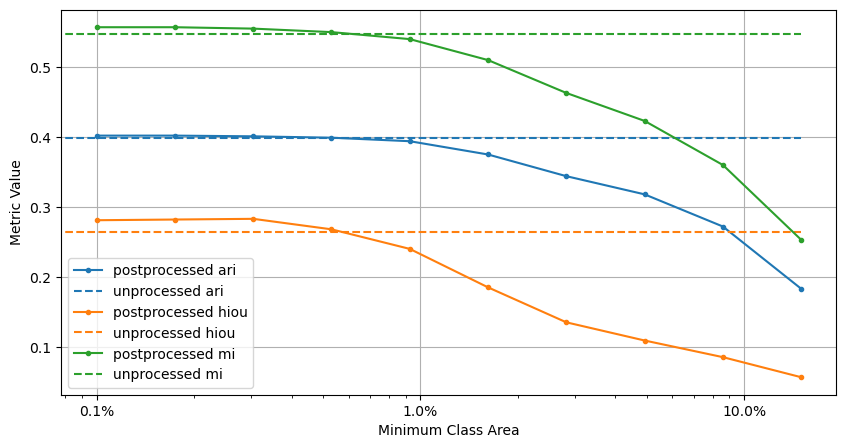

In [71]:
mean_metrics = ssm.mean_metric_table(to_df=True)
metric_keys = ["ari","hiou","mi"]
ref_col = "sam2_l"
plt.figure(figsize=(10,5))
for k,m in enumerate(metric_keys):
    vals = [float(x) for x in mean_metrics.loc[m]]
    plt.plot(min_areas,vals[1:],".-",label=f"postprocessed {m}",color=f"C{k}")
    refv = mean_metrics.loc[m][ref_col]
    plt.plot([0,max(min_areas)], [vals[0],vals[0]],"--",label=f"unprocessed {m}",color=f"C{k}")
plt.grid()
plt.xlabel("Minimum Class Area")
plt.xscale("log")
plt.ylabel("Metric Value")
plt.legend()

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1%}"))

## scatter of sam1 and sam2

In [17]:
import torch

torch.tensor([torch.tensor([1]),torch.tensor([1]),torch.tensor([1])]).shape

torch.Size([3])

# visualize data

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
sys.path.append('./source/')
import matplotlib.pyplot as plt
from source.utils.mixed import set_random_seed
from source.utils.dataloading import get_dataset_from_args
from source.utils.plot import (visualize_dataset_with_labels, 
                              visualize_batch,visualize_cond_batch)
from source.utils.argparsing import TieredParser
import jlc
modified_args={"diff_channels": 6,
                "dl_num_workers": 0,
                "p_semantic": 1,
                "semantic_dl_prob": 1,
                "seed": 2,
                "image_size": 256,
                "datasets": "visor"}
args = TieredParser().get_args(alt_parse_args=["--model_name","g25[COND]"],modified_args=modified_args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


processing dataset:  visor


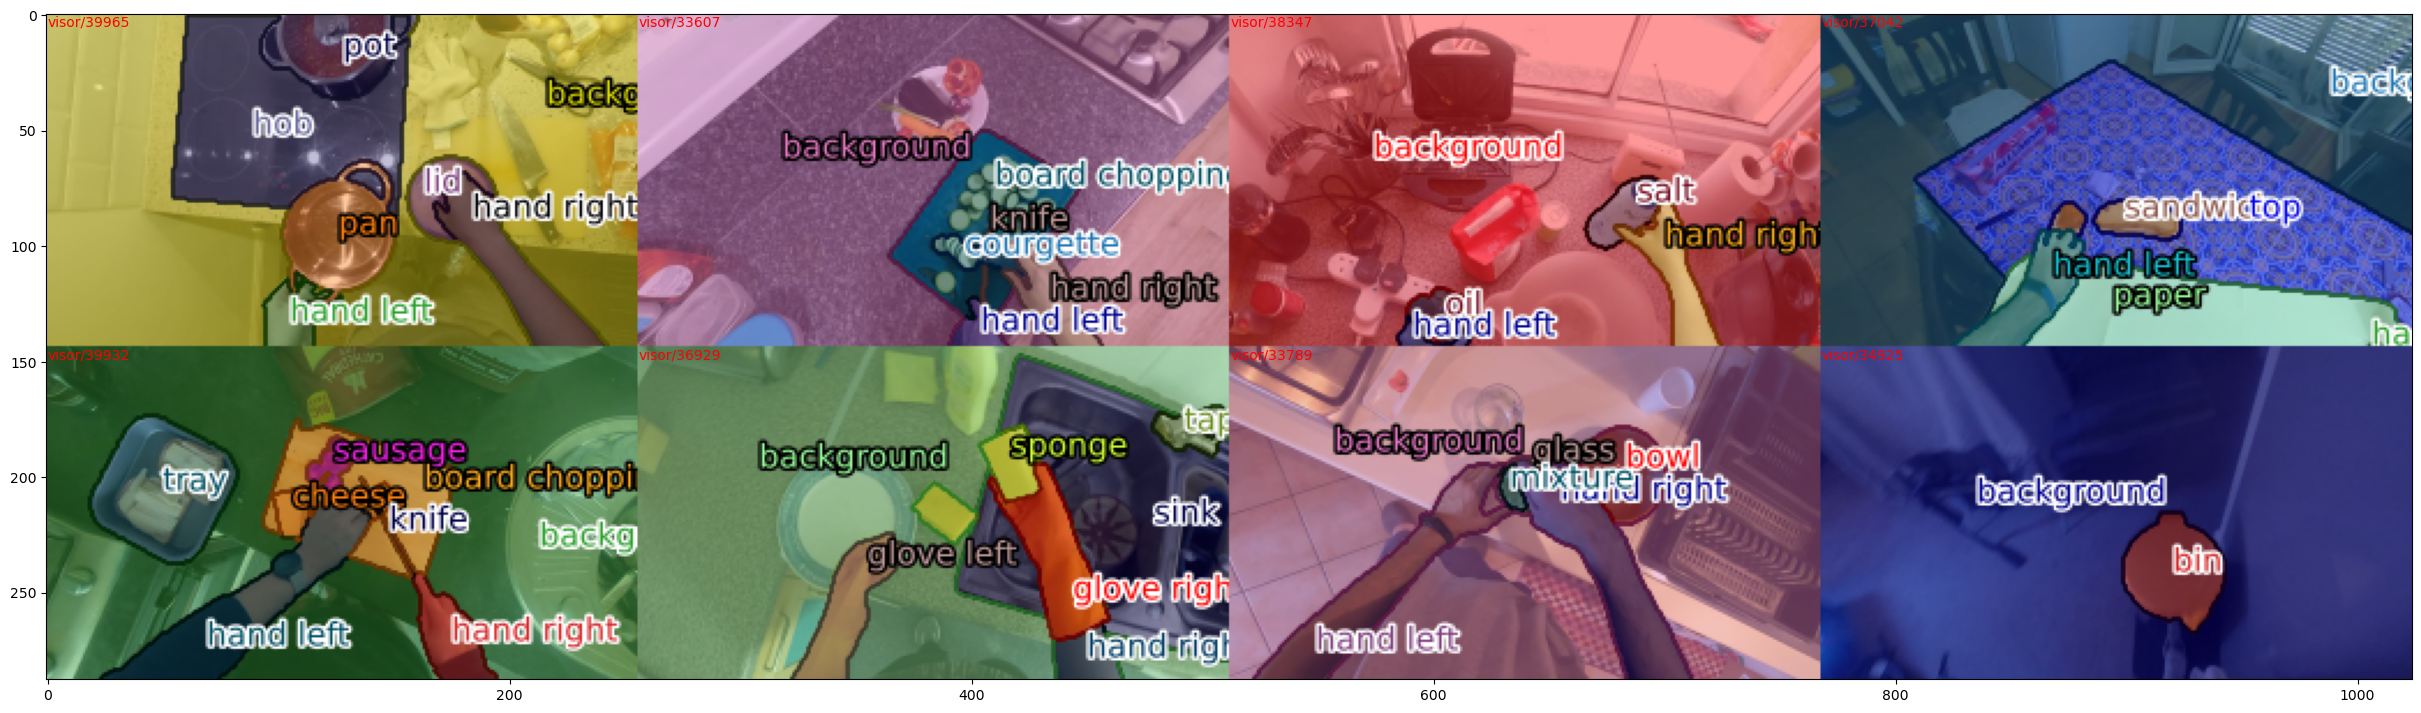

In [22]:


dli = get_dataset_from_args(args)
#dli.dataloader.dataset.map_excess_classes_to = "random_different"
batch = next(dli)
visualize_batch(batch,figsize_per_pixel=0.03,class_text_size=10,with_class_names=1,with_text_didx=1,alpha_mask=0.4,show_border=1,crop=1)

In [39]:
set_random_seed(2)
dli = get_dataset_from_args(args)
montage_im = visualize_cond_batch(dli=dli,
                                num_images=4,
                                montage_kwargs={"figsize_per_pixel": 0.1},
                                crop=False,
                                add_class_names=True,
                                overlay_fontsize=None,
                                didx_text_inside=True)
                                
#plt.figure(figsize=(20,20))
plt.imshow(montage_im)
jlc.zoom()

processing dataset:  visor


# training copy pasters

In [ ]:
python train.py --model_name g25+slow
python train.py --model_name g25+slow+128
f


In [ ]:
python train.py --model_name g25[cond]+slow
python train.py --model_name g25[COND][cont]
python train.py --model_name g25[COND][cont128]
f

In [ ]:
python train.py --model_name g25[COND]+slow --num_channels 128
python train.py --model_name g25[COND]+slow+128
f

In [ ]:
python sample.py --name_match_str *g25[COND]+slow+128_1 --gen_setup fast[kwargs_sweep] --guidance_weight 2.0 --gen_id gw_*
python sample.py --name_match_str *g25[COND]+slow+128_1 --gen_setup fast[kwargs_sweep] --num_samples 64 --gen_id many_*
python train.py --model_name g25[sem] --datasets high-qual --max_iter 100000
python train.py --model_name g25[sem] --max_iter 100000
python train.py --model_name g25[sem][COND] --max_iter 100000
python train.py --model_name g25[sem][COND]+slow+128
f

In [ ]:
python train.py --model_name g25[sem]+slow+128
python train.py --model_name g25[sem][hq]+slow
python train.py --model_name g25[sem][hq]+slow --num_channels 128
f

In [ ]:
python train.py --model_name lidc[v2][lr_sweep]
python train.py --model_name lidc[v2][nc_sweep]
f

In [ ]:
"b_sweep": { "input_scale": "0.3,0.1;0.03;0.01;0.003;0.001"},
            "loss_w_sweep": {"loss_weights": "SNR;SNR_trunc;uniform"},
            "loss_f_sweep": {"loss_type": "ce1;ce2"},
            "bce": {"bce_loss": true},
            "predict_sweep": {"predict": "v;eps;both;p;p_logits"}

In [ ]:
python train.py --model_name lidc[v3]+128
python train.py --model_name lidc[v3][b_sweep]
python train.py --model_name lidc[v3][loss_w_sweep]
python train.py --model_name lidc[v3][loss_f_sweep]
python train.py --model_name lidc[v3][bce]
python train.py --model_name lidc[v3][predict_sweep]
f

In [ ]:
# 07/10/2024
python train.py --model_name lidc[v3] --model_id lidcv3_1
python train.py --model_name lidc[v3][b_sweep]
python train.py --model_name lidc[v3] --deeper_net 1
python train.py --model_name lidc[v3] --deeper_net 1 --attention_resolutions "-1,-2,-3"
python sample.py --name_match_str *lidcv3* --gen_setup lidc_eval[amb][nosave][gw_sweep] --gen_id lidc_gw_sweep_*
python sample.py --name_match_str *lidcv3* --gen_setup lidc_eval[amb][nosave][ts_sweep] --gen_id lidc_ts_sweep_*
f

In [ ]:
python sample.py --name_match_str *lidcv3* --gen_setup lidc_eval[amb][nosave][ts_sweep] --gen_id lidc_ts_sweep_*
python sample.py --name_match_str *lidc[v3][b_sweep]_* --gen_setup lidc_eval[amb][nosave] --gen_id lidc_b_sweep_*
f

In [ ]:
# 09/10/2024
python train.py --model_name lidc[v3][b_sweep] --input_scale "1.0;0.5;0.05"
python train.py --model_name lidc[v3][opt]
f

In [ ]:
python sample.py --name_match_str *lidc[v3][b_sweep]_* --gen_setup lidc_eval[nosave][ambopt] --gen_id lidc_b_sweep2_*
f

In [ ]:
# 10/10/2024
cd ~/Desktop/diff/Ambiguous-Medical-Image-Segmentation-using-Diffusion-Models
python scripts/segmentation_train.py
cd ../diffusion2/
python train.py --model_name lidc[v4] --model_id lidcv4
python train.py --model_name lidc[v4][128]
python sample.py --name_match_str *lidcv4 --gen_setup lidc_eval[ambopt][nosave] --kwargs_mode image,self_cond
python sample.py --name_match_str *lidcv4 --gen_setup lidc_eval[ambopt][nosave][gw_sweep] --gen_id lidc_gw_sweep2_*
f

In [ ]:
# 11/10/2024
python train.py --model_name lidc[v4] --max_iter 100000 --num_channels 64 --deeper_net 1 

# plotting raw samples

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
import numpy as np
from source.eval_and_plotting import DiffSamples, SavedSamples, SavedSamplesManager
from source.utils.mixed import load_json_to_dict_list, save_dict_list_to_json
sys.path.append('./source/')
import matplotlib.pyplot as plt
from source.utils.metric_and_loss import get_ambiguous_metrics
from source.utils.mixed import set_random_seed
from source.utils.dataloading import get_dataset_from_args
from source.utils.plot import (visualize_dataset_with_labels, 
                              visualize_batch,visualize_cond_batch)
from source.utils.argparsing import TieredParser
import jlc
import torch
import tqdm

In [98]:
## multiple votes ambiguous

gen_id = "lidc_eval[ambopt]_0"
#gen_id = "lidc_eval_9"
diff_samples = DiffSamples(gen_id)
diff_samples.is_ambiguous = True
diff_samples.load_light_data()
diff_samples.load_heavy_data()
diff_samples.load_heavy_image_gt()


In [99]:
jlc.shaprint(diff_samples.heavy_data[0])

{'gt': 'torch.Size([4, 1, 64, 64])',
 'image': 'np.Size([64, 64, 3])',
 'info': [{'dataset_name': '<str>len9', 'i': '<int>len-1'}],
 'pred_int': 'torch.Size([4, 1, 64, 64])'}


In [100]:
diff_samples.recompute_metrics()

gts: [torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64])]
segs: [torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64]), torch.Size([4, 1, 64, 64])]


In [25]:
diff_samples.heavy_keys()

['info', 'pred_int', 'raw_image', 'raw_gt', 'ambiguous_gts']

In [48]:
jlc.shaprint(prob_unet_ss.heavy_data[0])

{'ambiguous_gts': 'np.Size([128, 128, 4])',
 'gt': 'np.Size([128, 128, 1])',
 'image': 'np.Size([128, 128, 3])',
 'pred_int': 'np.Size([4, 128, 128])'}


In [8]:
tn,fp,fn,tp=0,16,1,1044463
2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))

-1.8021947127211517e-06

In [102]:
ssm = SavedSamplesManager(diff_samples)
ssm.mean_metric_table()

lidc_eval[ambopt]_0
CI                  0.615
D_a                 0.998
D_max               0.729
GED                 0.383
S_c                 0.728
ari                 0.456
hiou                  0.7
iou                   0.7
mi                  0.413

In [107]:
del diff_samples

In [111]:
p = "/home/jloch/Desktop/diff/Probabilistic-Unet-Pytorch/saves/vali_eval.pth"
loaded = torch.load(p)
light_data = []
heavy_data = []
didx = []
n = len(loaded["info"])
for i in range(n):
    info_i = loaded["info"][i]
    pred_i = loaded["pred_int"][i]
    didx_i = f"{info_i['dataset_name']}/{info_i['i']}"

    if didx_i in didx:
        i = didx.index(didx_i)
        heavy_data[i]["pred_int"].append(pred_i)
    else:
        didx.append(didx_i)
        light_data.append(info_i)
        heavy_data.append({"pred_int": [pred_i]})
for hd in heavy_data:
    hd["pred_int"] = torch.cat(hd["pred_int"],axis=0).unsqueeze(1)

prob_unet_ss = SavedSamples(light_data=light_data,
                            heavy_data=heavy_data,
                            didx=didx,
                            is_ambiguous=True)
del loaded
del heavy_data

In [117]:
prob_unet_ss.load_heavy_image_gt()
for i in range(len(prob_unet_ss.heavy_data)):
    del prob_unet_ss.heavy_data[i]["gt"]
prob_unet_ss.recompute_metrics()

In [118]:
ssm = SavedSamplesManager(prob_unet_ss)
ssm.mean_metric_table()

unnamed
CI      0.629
D_a     0.997
D_max    0.75
GED     0.449
S_c     0.715
ari     0.398
hiou    0.676
iou     0.676
mi       0.37

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

p = "/home/jloch/Desktop/CP2024/programmering/pg_cs/images/banners/"
#load all files in folder and concat to large image across vertical axis
file_paths = sorted(list(Path(p).glob("*")))
images = []
for f in file_paths:
    images.append(plt.imread(f))
im = np.concatenate(images,axis=0)
#save
plt.imsave(Path(p)/ "full_banner.png",im)

## small test. fast_12 id

In [4]:
gen_id = "fast_12"
diff_samples = DiffSamples(gen_id)
diff_samples.load_light_data()
diff_samples.load_heavy_data()

{'top': ['Raw\n Image', 'Ground\n Truth', 'fast_12'], 'left': ['   visor/35080  ', '   visor/36449  ', '   visor/39768  ', '   visor/40096  '], 'xtick_kwargs': {'fontsize': 10}}


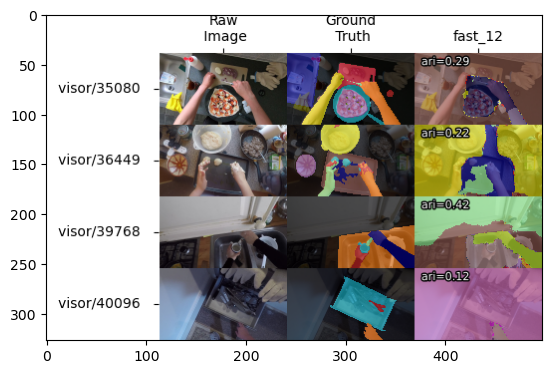

In [6]:
ssm = SavedSamplesManager(diff_samples)
plt.imshow(ssm.plot_qual_seg())

In [10]:
ssm.mean_metric_table()

adjacent same_dataset  same_vol same_classes self_cond num_labels
ari     0.301        0.241     0.223        0.241     0.311      0.237
hiou   0.0544       0.0508    0.0501        0.049    0.0409     0.0532
iou   0.00236      0.00173  0.000382      0.00049  0.000828   0.000708
mi      0.325        0.275     0.248        0.283     0.313      0.283

## kwargs sweep over visor, g25[COND]

In [6]:
gen_id_dict = {"basic": [f"fast[kwargs_sweep]_{i}" for i in range(2,9)],
               "gw": [f"gw_{i}" for i in range(7)],
               "many": [f"many_{i}" for i in range(7)],
               "sem": [f"fast[kwargs_sweep]_{i}" for i in range(9,16)]}
gen_ids = gen_id_dict["sem"]

ssm = SavedSamplesManager()
for gen_id in gen_ids:
    diff_samples = DiffSamples(gen_id)
    diff_samples.load_light_data()
    diff_samples.load_heavy_data()
    ssm.add_saved_samples(diff_samples)
ssm.rename_by_opts_key()
ssm.mean_metric_table(convert_to_pct=1,significant_digits=1,add_max_reduction=0)

image adjacent same_dataset same_vol same_classes self_cond num_labels
ari   14.1     33.2         12.0     14.9         20.8      13.3       13.2
hiou   4.7      8.3          5.1      5.8          5.6       4.6        5.0
iou    0.1      0.1          0.1      0.1          0.1       0.0        0.1
mi    19.9     33.2         18.4     19.4         24.1      18.2       21.8

In [ ]:
ssm.bar(add_max_reduction=1);

In [5]:
for i in range(len(ssm.saved_samples)):
    ssm.saved_samples[i] = ssm.saved_samples[i].reduce_to_only_heavy()
    ssm.saved_samples[i].postprocess({"mode": "min_area", "min_area": 0.005})

ssm.mean_metric_table(convert_to_pct=1,significant_digits=1)

image adjacent same_dataset same_vol same_classes self_cond num_labels
ari   34.8     45.2         31.1     25.6         30.2      36.1       28.5
hiou  24.6     24.2         22.1     18.5         23.2      25.7       21.8
iou    0.4      2.9          0.1      1.0          4.4       0.2        0.6
mi    35.6     44.7         34.4     24.5         30.3      36.9       31.6

In [16]:
%matplotlib qt5
plt.imshow(ssm.plot_qual_seg())
jlc.zoom()

## lidc matching

In [102]:
#collect samples

gen_id = "actual_ged_1"
diff_samples = DiffSamples(gen_id)
diff_samples.load_light_data()
diff_samples.load_heavy_data(extract=0)
diff_samples.add_gt_image_to_heavy_data(longest_side_resize=64)

In [106]:
split_idx = 1
info_path = "/home/jloch/Desktop/diff/diffusion2/data/lidc/info.jsonl"
info = load_json_to_dict_list(info_path)
i_to_maskname = {}
for x in info:
    if x["split_idx"]==split_idx:
        i_to_maskname[x["i"]] = int(x["fn"].split(",")[-1].split("_")[1].split(".")[0])

data_path = "/home/jloch/Desktop/diff/diffusion2/data/lidc/lidcshare3/data.jsonl"
data = load_json_to_dict_list(data_path)
mask_to_image_id = {}
for x in data:
    for nod in x["nodules"]:
        for image_dict in nod:
            for mask_id in image_dict["masks_id"]:
                mask_to_image_id[mask_id] = image_dict["image_id"]

i_to_group = {k: mask_to_image_id[v] for k,v in i_to_maskname.items()}

groups = {}
for ld in diff_samples.light_data:
    i = ld["info"]["i"]
    assert i in i_to_group, f"i={i} not in i_to_group"
    g = i_to_group[i]
    if not g in groups:
        groups[g] = []
    groups[g].append(i)
    
print(f"Found {len(i_to_group)} images in split {split_idx}")
print(f"Found {len(diff_samples.heavy_data)} samples in {gen_id}")
all_are_matches = sorted(list(i_to_group.keys()))==sorted([int(x.split("/")[1]) for x in diff_samples.didx])
print(f"Are all matches? {all_are_matches}")
if False:
    #make a nice hist of group sizes
    counts_per_group = np.unique(list(i_to_group.values()),return_counts=True)[1]
    plt.hist(counts_per_group,bins=np.arange(1,10)-0.5)
    plt.ylabel("Amount")
    plt.xlabel("Number of Images per Group")

Found 4490 images in split 1
Found 4490 samples in lidc_eval_9
Are all matches? True


In [114]:
to_np = lambda x: x.cpu().numpy() if isinstance(x,torch.Tensor) else x
def extract_ambiguous_metrics(diff_samples,groups,min_group_size=None,max_group_size=None,shorthand=False):
    dataset_name = "lidc" #for now

    if min_group_size is not None:
        groups = {k:v for k,v in groups.items() if len(v)>=min_group_size}
    if max_group_size is not None:
        groups = {k:v for k,v in groups.items() if len(v)<=max_group_size}
    measures = {}
    for g,group_indices in tqdm.tqdm(groups.items()):
        g_gt = []
        g_pred = []
        for i in group_indices:
            assert diff_samples.heavy_available[f"{dataset_name}/{i}"]=="pos_loaded", f"i={i} not loaded"
            hd = diff_samples.get_heavy_data(f"{dataset_name}/{i}")[f"{dataset_name}/{i}"]
            g_gt.append(hd["gt"])
            g_pred.append(hd["pred_int"])
            g_pred.append(np.ones_like(hd["pred_int"]))
        g_gt = np.concatenate(g_gt,axis=-1)
        g_pred = np.concatenate(g_pred,axis=-1)
        measures_i = get_ambiguous_metrics(g_gt,g_pred,shorthand=shorthand)
        measures[g] = measures_i
    return measures

In [115]:
measures = extract_ambiguous_metrics(diff_samples,groups,min_group_size=4,max_group_size=None)
mean_metrics = {m: np.mean([v[m] for v in measures.values()]) for m in measures[list(measures.keys())[0]]}
for m,v in mean_metrics.items():
    print(f"{m}: {v:.3f}")

100%|██████████| 638/638 [00:03<00:00, 209.23it/s]

combined_sensitivity: 1.000
maximum_dice_matching: 0.750
diversity_agreement: 0.997
collective_insight: 0.800
generalized_energy_distance: 0.670


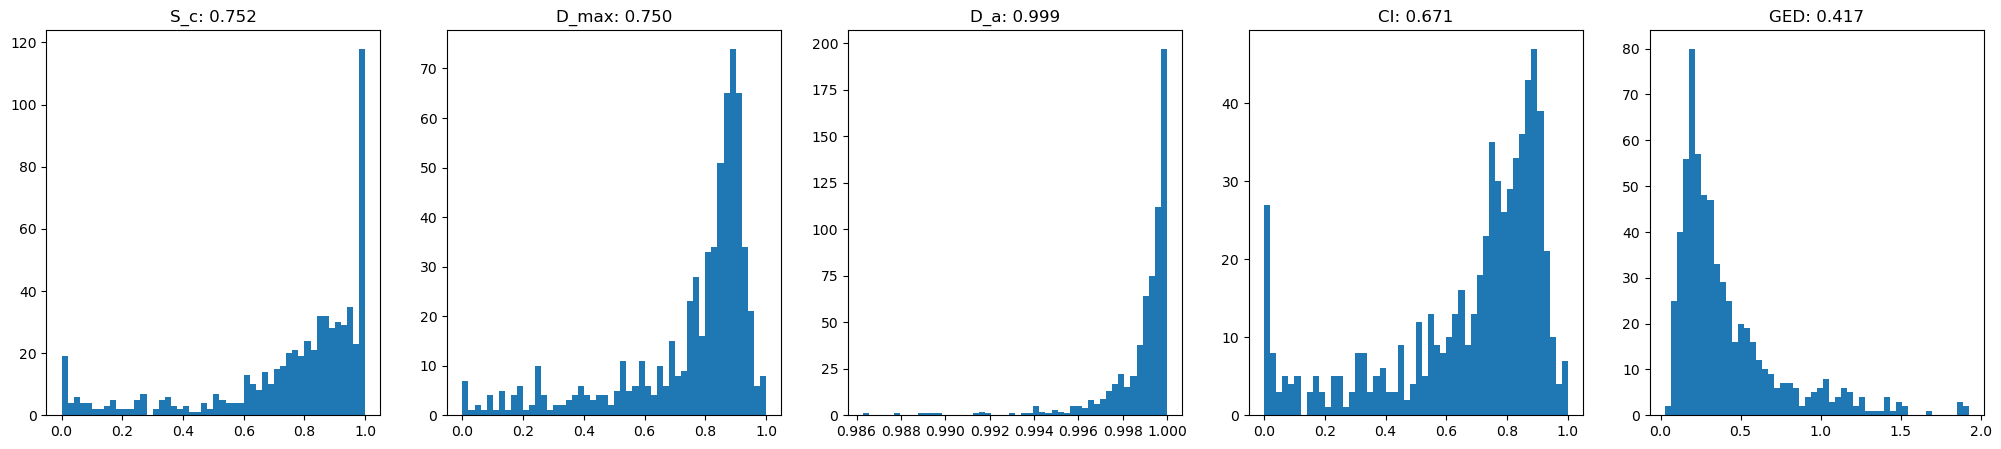

In [113]:
from source.utils.metric_and_loss import shorthand_dict
plt.figure(figsize=(5*len(mean_metrics),5))
i = 1
for m,v in mean_metrics.items():
    plt.subplot(1,len(mean_metrics),i)
    plt.title(f"{shorthand_dict[m]}: {v:.3f}")
    plt.hist([v[m] for v in measures.values()],bins=50)
    i+=1

In [22]:
def get_qual_samples(n,measures,i_to_group,measure="combined_sensitivity",min_val=None,max_val=0.1):
    """Loops over measures to find the measure keys with measures
    in the correct range. Raises an error if too few samples are found
    """
    groups = []
    measures_per_group = []
    for g,measure_dict in measures.items():
        if min_val is not None:
            if min_val>measure_dict[measure]:
                continue
        if max_val is not None:
            if max_val<measure_dict[measure]:
                continue
        groups.append(g)
        measures_per_group.append(measure_dict)
        if len(groups)>=n:
            break
    if len(groups)<n:
        raise ValueError(f"Only {len(groups)} samples found in range. Consider increasing range or requesting fewer samples")
    keys_out = [[] for _ in range(n)]
    for i,g in i_to_group.items():
        if g in groups:
            keys_out[groups.index(g)].append(i)
    return keys_out, measures_per_group, groups

keys_out, measures_per_group, groups = get_qual_samples(4,measures,i_to_group)
print(keys_out)
print(groups)
print([m["combined_sensitivity"] for m in measures_per_group])


[[11917, 11918, 11919, 11920], [10472, 10473, 10474, 10475], [39835, 39836, 39837, 39838], [6470, 6471, 6472, 6473]]
[3759, 3338, 13618, 2083]
[0.0, 0.0, 0.0, 0.0]


{'combined_sensitivity': 0.0, 'maximum_dice_matching': 0.921875, 'diversity_agreement': 0.9656448364257812, 'collective_insight': 0.0, 'generalized_energy_distance': -0.011179603965535079}
(512, 384, 3)
(1024, 768, 3)


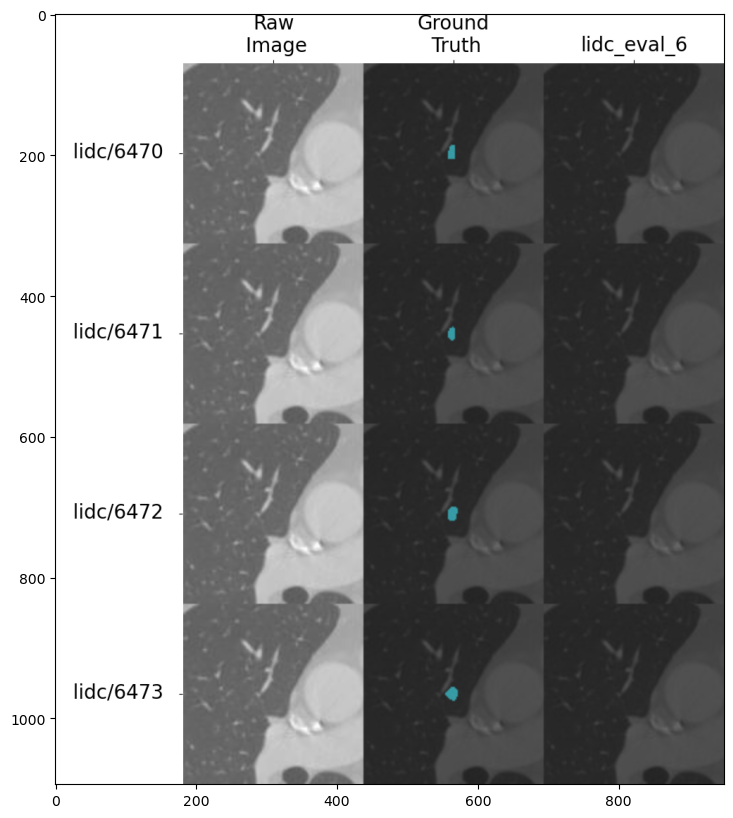

In [23]:
ssm = SavedSamplesManager(diff_samples)
i = 3
didx_plot = [f"lidc/{k}" for k in keys_out[i]]
print(measures_per_group[i])
im = ssm.plot_qual_seg(didx=didx_plot,pixel_mult=2,add_text_inside=False)
plt.figure(figsize=(10,10))
plt.imshow(im)

## hits of measures lidc GED

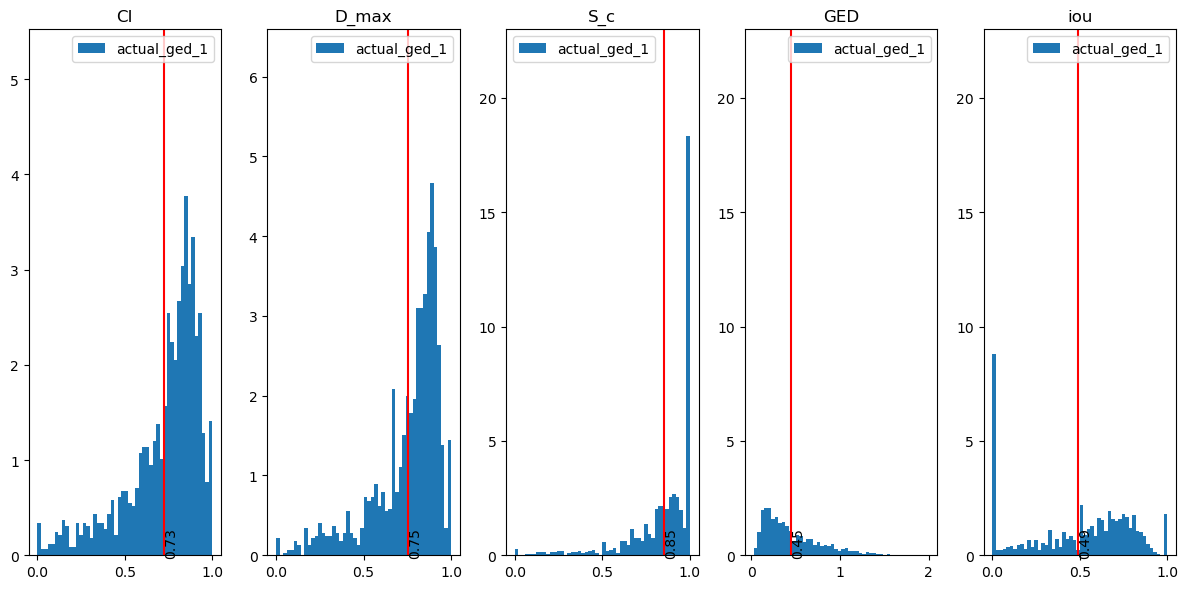

In [2]:
ssm = SavedSamplesManager()
gen_ids = ["actual_ged_1","actual_ged_2"]
for gen_id in gen_ids:
    diff_samples = DiffSamples(gen_id)
    diff_samples.load_light_data()
    ssm.add_saved_samples(diff_samples)
plot_metrics = ["CI","D_max","S_c","GED","iou"]
#plot_metrics = ["GED"]
ssm.hist(ss_idx=[0],metric_names=plot_metrics,bins=50,subplot_per_metric=1,unit_xlim=False,mean_lines=True)

# LDIC processing from paper

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2
import jlc
from pathlib import Path
data_folder = "/home/jloch/Desktop/diff/Ambiguous-Medical-Image-Segmentation-using-Diffusion-Models/data"

data = {}
for im_path in tqdm.tqdm(Path(data_folder).glob("*/*/image_*.jpg")):
    data[im_path.name] = {"im": plt.imread(im_path)}
    for label_path in Path(im_path).parent.glob("label*_.jpg"):
        data[im_path.name][label_path.name] = plt.imread(label_path)>=128

        

28it [00:00, 1603.63it/s]


Mean X: 64.5, Mean Y: 65.0


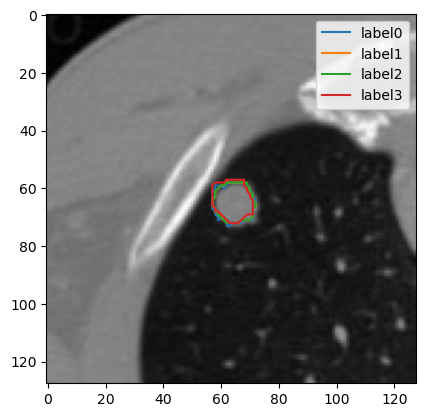

In [91]:

def get_contour(label,connect=False):
    if not any(label.flatten()):
        return [],[]
    contours = cv2.findContours(label.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x = contours[0][0][:,0,0]
    y = contours[0][0][:,0,1]
    if connect:
        x = np.concatenate([x,[x[0]]])
        y = np.concatenate([y,[y[0]]])
    return x,y

def get_bbox(label):
    if not any(label.flatten()):
        return [float("nan")]*4
    return [np.min(np.where(label)[0]),
                 np.max(np.where(label)[0]),
                 np.min(np.where(label)[1]),
                 np.max(np.where(label)[1])]
k0 = list(data.keys())[6]
plt.imshow(data[k0]["im"],cmap="gray")
labelsum = 0
for i in range(4):
    label = data[k0][f"label{i}_.jpg"]
    labelsum += label
    x,y = get_contour(label,1)
    plt.plot(x,y,label=f"label{i}")
plt.legend()
bbox2 = get_bbox(labelsum>=1)
print(f"Mean X: {np.mean(bbox2[2:]):.1f}, Mean Y: {np.mean(bbox2[:2]):.1f}")

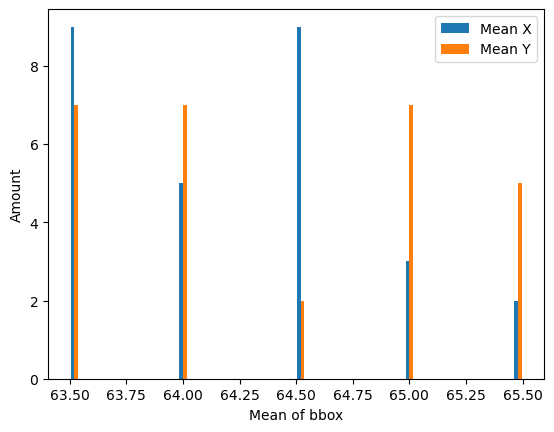

In [90]:
mean_x = []
mean_y = []
for k0 in list(data.keys()):
    labelsum = 0
    num_non_empty_labels = 0
    for i in range(4):
        label = data[k0][f"label{i}_.jpg"]
        labelsum += label
        num_non_empty_labels += any(label.flatten())
        x,y = get_contour(label,1)
    bbox2 = get_bbox(labelsum>=(num_non_empty_labels-1)//2)
    mean_x.append(np.mean(bbox2[2:]))
    mean_y.append(np.mean(bbox2[:2]))
    
plt.hist([mean_x,mean_y],bins=50,label=["Mean X","Mean Y"])
plt.legend()
plt.xlabel("Mean of bbox")
plt.ylabel("Amount")
plt.show()

In [72]:
data[list(data.keys())[1]]["im"]

array([[15, 17, 22, ...,  3,  3,  2],
       [11, 11, 12, ...,  4,  4,  3],
       [14, 12, 10, ...,  4,  3,  3],
       ...,
       [12, 10, 18, ..., 68, 69, 72],
       [13, 12, 19, ..., 67, 67, 70],
       [ 8, 11, 17, ..., 69, 69, 68]], dtype=uint8)

Bbbox with thresh=0 [0, 127, 0, 127]
Bbbox with thresh=1 [59, 70, 59, 69]
Bbbox with thresh=2 [60, 68, 60, 68]
Bbbox with thresh=3 [60, 68, 61, 68]


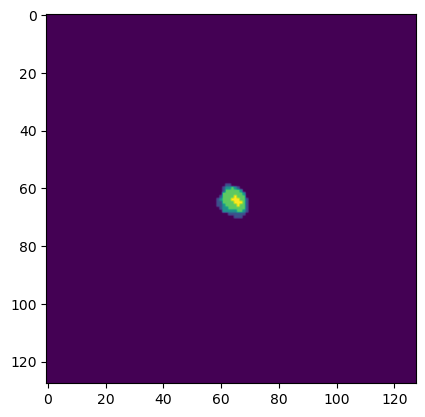

In [10]:
labelsum = np.sum([data[k0][f"label{i}_.jpg"] for i in range(4)],axis=0)
plt.imshow(labelsum)
for i in range(4):
    print(f"Bbbox with thresh={i}",)

In [5]:
Y_bbox

[64.0, 64.5, 64.0, 64.5]

In [ ]:
def nice_ldic_image(d):
    non_im_keys = [k for k in d.keys() if k!="im"]
    with jlc.RenderMatplotlibAxis(d["im"]) as renderer:
        for k in non_im_keys:
            renderer.overlay(d[k],alpha=0.5)
    im = renderer.image
    return im
k0 = list(data.keys())[0]
im = nice_ldic_image(data[k0])
plt.imshow(im)

In [21]:
%matplotlib qt5

In [22]:
lab = data[k0]['label2_.jpg']
plt.imshow(lab)
print(np.unique(lab))

[  0   1   2   3   4   5   6 250 251 252 253 254 255]


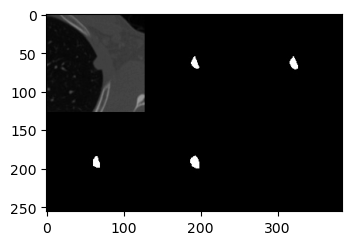

In [19]:

jlc.montage(list(data[k0].values()))

# LDIC processing from dataset

In [99]:
from source.utils.mixed import load_json_to_dict_list, save_dict_list_to_json
import numpy as np
from PIL import Image
data_path = "/home/jloch/Desktop/diff/diffusion2/data/lidc/lidcshare3/data.jsonl"
data = load_json_to_dict_list(data_path)

def get_slice_bbox(mask):
    assert np.any(mask), "mask is empty"
    if len(mask.shape)==3:
        mask = mask.any(axis=-1)
    b1,b2 = np.where(mask.any(axis=1))[0][[0,-1]]
    b3,b4 = np.where(mask.any(axis=0))[0][[0,-1]]
    return b1,b2+1,b3,b4+1

print(data[0])

for scan in data:
    for nod in scan["nodules"]:
        for image_dict in nod:
            mask = [Image.open(Path(data_path).parent/"masks"/f"mask_{m:06d}.png") for m in image_dict["masks_id"]]
            mask = np.concatenate([np.array(m)[...,None] for m in mask],axis=-1)
            bbox = get_slice_bbox(mask)
            image_dict["bbox"] = bbox
            break

print(data[0])
#save_dict_list_to_json(data,"/home/jloch/Desktop/diff/diffusion2/data/lidc/lidcshare2/data_bbox.jsonl")

{'patient_id': 'LIDC-IDRI-0078', 'pixel_spacing': 0.65, 'slice_thickness': 3.0, 'id': 1, 'nodules': [[{'bbox': [295, 317, 312, 343], 'slice': 23, 'image_id': 0, 'masks_id': [0, 1, 2, 3]}, {'bbox': [300, 325, 317, 345], 'slice': 24, 'image_id': 1, 'masks_id': [4, 5, 6, 7]}, {'bbox': [303, 327, 316, 347], 'slice': 25, 'image_id': 2, 'masks_id': [8, 9, 10, 11]}, {'bbox': [299, 327, 310, 347], 'slice': 26, 'image_id': 3, 'masks_id': [12, 13, 14, 15]}, {'bbox': [298, 326, 307, 348], 'slice': 27, 'image_id': 4, 'masks_id': [16, 17, 18, 19]}, {'bbox': [302, 319, 323, 341], 'slice': 28, 'image_id': 5, 'masks_id': [20, 21, 22, 23]}], [{'bbox': [157, 179, 352, 372], 'slice': 44, 'image_id': 6, 'masks_id': [24, 25, 26, 27]}, {'bbox': [147, 185, 351, 373], 'slice': 45, 'image_id': 7, 'masks_id': [28, 29, 30, 31]}, {'bbox': [153, 184, 350, 375], 'slice': 46, 'image_id': 8, 'masks_id': [32, 33, 34, 35]}, {'bbox': [159, 183, 350, 373], 'slice': 47, 'image_id': 9, 'masks_id': [36, 37, 38, 39]}, {'bbox

In [100]:
num_nods = 0
num_images = 0
num_masks_per_image = []
for scan in data:
    for nod in scan["nodules"]:
        num_nods += 1
        for image_dict in nod:
            num_images += 1
            num_masks_per_image.append(len(image_dict["masks_id"]))

print(f"Found {num_nods} nodules in {num_images} images")

Found 2769 nodules in 16321 images


In [ ]:
info_path = "/home/jloch/Desktop/diff/diffusion2/data/lidc/info.jsonl"
info = load_json_to_dict_list(info_path)

mask_ids = []
for info_i in info:
    mask_id = info_i["fn"].split(",")[-1]
    if mask_id in mask_ids:
        print(f"Found duplicate mask_id {mask_id}")
    mask_ids.append(mask_id)

# Collective insight development

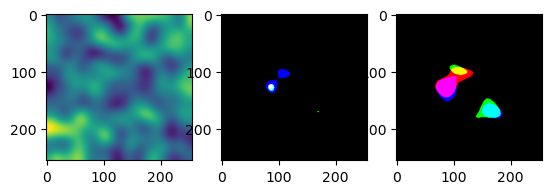

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import jlc
def rand_im(n,std):
    im = np.random.rand(n,n)
    im = nd.gaussian_filter(im,std*n)
    im = jlc.quantile_normalize(im)
    return im

def dummy_data(n,num_segments,std_im=0.05,
                ratio_pred=0.4,
                ratio_gt=0.2,
                std_pred=0.1,
                std_gt=0.1,
                t=0.5):
    """Generates dummy data which is an image of size n x n with 
    num_segments predictions and ground truths. The image is filtered
    random noise and segments is the same but with a bias towards 
    central single connected components."""
    
    im = rand_im(n,std_im)
    X,Y = np.meshgrid(np.arange(n),np.arange(n))
    circle = 1-((X-n/2)**2+(Y-n/2)**2)/(n**2/4)
    ground_truths = np.zeros((n,n,num_segments),dtype=bool)
    preds = np.zeros((n,n,num_segments),dtype=bool)
    for i in range(num_segments):
        im_hidden_gt   = im*(1-ratio_gt  )+rand_im(n,std_gt  )*ratio_gt
        im_hidden_pred = im*(1-ratio_pred)+rand_im(n,std_pred)*ratio_pred
        im_hidden_gt   = im_hidden_gt  *circle
        im_hidden_pred = im_hidden_pred*circle
        ground_truths[:,:,i] = (im_hidden_gt  >t)
        preds[:,:,i]         = (im_hidden_pred>t)
    return im,ground_truths,preds

im,ground_truths,preds = dummy_data(256,5)
plt.subplot(1,3,1)
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(ground_truths[:,:,:3]*255)
plt.subplot(1,3,3)
plt.imshow(preds[:,:,:3]*255)


    

In [10]:
preds[130:] = 0
ground_truths[:125] = 0

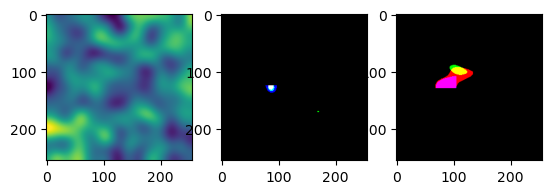

In [11]:
plt.subplot(1,3,1)
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(ground_truths[:,:,:3]*255)
plt.subplot(1,3,3)
plt.imshow(preds[:,:,:3]*255)

In [12]:
def get_TP_FP_FN_TN(gt,pred):
    TP = np.sum(gt&pred)
    FP = np.sum(~gt&pred)
    FN = np.sum(gt&~pred)
    TN = np.sum(~gt&~pred)
    return TP,FP,FN,TN

def collective_insight(gt,pred):
    assert gt.max()<=1 and pred.max()<=1
    n_gt = gt.shape[-1]
    n_pred = pred.shape[-1]

    measures = {"combined_sensitivty": float("nan"),
                "maximum_dice_matching": float("nan"),
                "diversity_agreement": float("nan")}
                
    TP,FP,FN,TN = get_TP_FP_FN_TN(gt.any(-1),pred.any(-1))
    if TP+FP+FN==0: 
        #edge case 1
        #both are empty, the combined sensitivity is 1
        measures["combined_sensitivty"] = 1.0
    elif TP+FN==0 and FP>0: 
        #edge case 2
        #ground truth is empty, but prediction is not, the combined sensitivity is 0
        measures["combined_sensitivty"] = 0.0
    else:
        measures["combined_sensitivty"] = TP/(TP+FN)

    dice_mat = np.zeros((n_gt,n_pred))
    for i in range(n_gt):
        for j in range(n_pred):
            TP,FP,FN,TN = get_TP_FP_FN_TN(gt[:,:,i],pred[:,:,j])
            dice_mat[i,j] = 2*TP/(2*TP+FP+FN)
    measures["maximum_dice_matching"] = dice_mat.max(axis=1).mean()

    variance_mat_pred = np.var(pred.reshape(-1,n_pred)[:,:,None].astype(int)-
                               pred.reshape(-1,n_pred)[:,None,:].astype(int),axis=0)
    variance_mat_gt = np.var(gt.reshape(-1,n_gt)[:,:,None].astype(int)-
                             gt.reshape(-1,n_gt)[:,None,:].astype(int),axis=0)
    V_pred_min = variance_mat_pred.min()
    V_pred_max = variance_mat_pred.max()
    V_gt_min = variance_mat_gt.min()
    V_gt_max = variance_mat_gt.max()
    delta_max = abs(V_pred_max-V_gt_max)
    delta_min = abs(V_pred_min-V_gt_min)
    measures["diversity_agreement"] = 1-(delta_max+delta_min)/2
    multiplied = np.prod([v for v in measures.values()])
    added = np.sum([v for v in measures.values()])
    measures["collective_insight"] = 3*multiplied/added
    return measures

collective_insight(ground_truths[:,:,:3],preds)

{'combined_sensitivty': 0.46411483253588515,
 'maximum_dice_matching': 0.2786749945421532,
 'diversity_agreement': 0.983145878650248,
 'collective_insight': 0.22102329738802381}

In [102]:
def binary_iou(TP,FP,FN,TN):
    if TP+FP+FN==0:
        return 1.0
    else:
        return TP/(TP+FP+FN)

def generalized_energy_distance(gt,pred,dist=binary_iou):
    n_gt = gt.shape[-1]
    n_pred = pred.shape[-1]
    dist_pred_gt = np.zeros((n_gt,n_pred))
    for i in range(n_gt):
        for j in range(n_pred):
            TP,FP,FN,TN = get_TP_FP_FN_TN(gt[:,:,i],pred[:,:,j])
            dist_pred_gt[i,j] = dist(TP,FP,FN,TN)
    dist_gt = {}
    for i in range(n_gt):
        for j in range(i,n_gt):
            TP,FP,FN,TN = get_TP_FP_FN_TN(gt[:,:,i],gt[:,:,j])
            dist_gt[(i,j)] = dist(TP,FP,FN,TN)
    dist_pred = {}
    for i in range(n_pred):
        for j in range(n_pred):
            TP,FP,FN,TN = get_TP_FP_FN_TN(pred[:,:,i],pred[:,:,j])
            dist_pred[(i,j)] = dist(TP,FP,FN,TN)
    expected_gt = np.array(list(dist_gt.values())).mean()
    expected_pred = np.array(list(dist_pred.values())).mean()
    ged = 2*dist_pred_gt.mean()-expected_gt-expected_pred
    print(dist_pred_gt.mean(),expected_gt,expected_pred)
    return ged

generalized_energy_distance(ground_truths[:,:,:],preds)

0.685500444268722 0.8660656433681361 0.6636837631233522


-0.1587485179540442

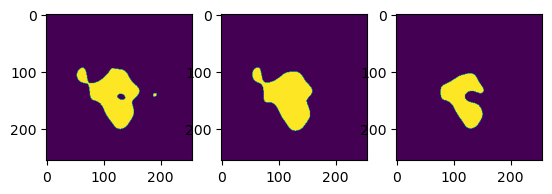

In [84]:
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(ground_truths[:,:,i])

In [107]:
from source.utils.metric_and_loss import standard_iou,hungarian_iou

p0 = preds[:,:,0]
gt0 = ground_truths[:,:,0]

print(standard_iou(gt0,p0))
print(hungarian_iou(gt0,p0,ignore_zero=False))

0.6724318748367357
0.6724318748367357


In [121]:
a = {'iou': 0.7482550692849831, 'hiou': 0.7482550692849831, 'ari': 0.5057634734466467, 'mi': 0.5045989974195542, 'S_c': 0.03773584905660377, 'D_max': 0.7681818181818182, 'D_a': 0.9878832101821899, 'CI': 0.04789286048294839, 'GED': 0.2492662473794549}
print("\n".join([f"{k:5}: {v:.3f}" for k,v in a.items()]))

iou  : 0.748
hiou : 0.748
ari  : 0.506
mi   : 0.505
S_c  : 0.038
D_max: 0.768
D_a  : 0.988
CI   : 0.048
GED  : 0.249


# run sampler

In [8]:
%load_ext autoreload
%autoreload 2

from source.sampling import DiffusionSampler
from source.utils.argparsing import TieredParser
from source.training import trainer_from_sample_opts
import jlc
import numpy as np

sample_opts = TieredParser("sample_opts").get_args(alt_parse_args=[ "--name_match_str","*lidc[v2][lr_sweep]_5*",
                                                                    "--gen_setup","lidc_eval[amb]",
                                                                    "--num_votes","3",
                                                                    "--return_samples", "1",
                                                                    "--plotting_functions", "grid",
                                                                    "--num_grid_samples", "2",
                                                                    "--num_samples", "2",
                                                                    "--do_agg", "0",
                                                                    "--ambiguous_mode", "1"])
trainer = trainer_from_sample_opts(sample_opts)
sampler = DiffusionSampler(trainer,sample_opts)

sample_output, metric_output = sampler.sample()
print(metric_output)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

ckpt_name: saves/ver-1.3.1/10-02-19-58_lidc[v2][lr_sweep]_5_(lr=1e-05)/ckpt_020000.pt
saves/ver-1.3.1/10-02-19-58_lidc[v2][lr_sweep]_5_(lr=1e-05)/args.json

model_id: lidc[v2][lr_sweep]_5
Setting up generation.
CUDA available. Using GPU.
Number of trainable parameters (UNet): 29 027 462
Number of trainable parameters (ViT): 0
Saving to: saves/ver-1.3.1/10-02-19-58_lidc[v2][lr_sweep]_5_(lr=1e-05)
Init complete.
Sampling with gen_id: lidc_eval[amb]_28
processing dataset:  lidc


Batch progress.: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'iou': [[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.2, 0.0, 1.0]], 'hiou': [[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.2, 0.0, 1.0]], 'ari': [[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3285179375805756, 0.0, 1.0]], 'mi': [[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.19376184050365386, 0.0, 1.0]], 'S_c': [0.03773584905660377, 0.17647058823529413], 'D_max': [0.7681818181818182, 0.6583333333333332], 'D_a': [0.9878832101821899, 0.9916636943817139], 'CI': [0.04789286048294839, 0.1892308196723433], 'GED': [0.2492662473794549, 0.3508496732026143], 'gen_setup': 'lidc_eval[amb]', 'gen_id': 'lidc_eval[amb]_28'}


In [31]:
jlc.shaprint(sample_output)

{'image': 'torch.Size([5, 3, 64, 64])',
 'info': [{'dataset_name': '<str>len4',
           'gts_didx': ['<str>len8', '<str>len8', '<str>len8', '<str>len8'],
           'i': '<int>len-1'},
          {'dataset_name': '<str>len4',
           'gts_didx': ['<str>len8', '<str>len8', '<str>len8', '<str>len8'],
           'i': '<int>len-1'},
          {'dataset_name': '<str>len4',
           'gts_didx': ['<str>len8', '<str>len8', '<str>len8', '<str>len8'],
           'i': '<int>len-1'},
          {'dataset_name': '<str>len4',
           'gts_didx': ['<str>len8', '<str>len8', '<str>len8', '<str>len8'],
           'i': '<int>len-1'},
          {'dataset_name': '<str>len4',
           'gts_didx': ['<str>len8', '<str>len8', '<str>len8', '<str>len8'],
           'i': '<int>len-1'}],
 'pred_bit': 'torch.Size([5, 3, 6, 64, 64])',
 'pred_int': 'torch.Size([5, 3, 1, 64, 64])',
 'target_bit': 'torch.Size([5, 6, 64, 64])',
 'target_int': 'torch.Size([5, 1, 64, 64])',
 'x_init': 'torch.Size([5, 6, 64, 64]

In [33]:
from source.utils.dataloading import load_raw_image_label
from source.utils.metric_and_loss import get_segment_metrics,get_ambiguous_metrics
i = 2
pred = sample_output["pred_int"][i]
n = len(pred)
target = sample_output["info"][i]

gts = []
h,w = pred.shape[-2:]
m = len(target["gts_didx"])
for didx in target["gts_didx"]:
    gts.append(load_raw_image_label(didx,longest_side_resize=max(h,w))[1][:,:,0])

assert all([gt.shape[-2:]==(h,w) for gt in gts]), f"all loaded targets must have the same spatial dimensions (h,w)=({h},{w}), found {[gt.shape for gt in gts]}"
gts = np.stack(gts,axis=-1)

pred = pred.squeeze(1).permute(1,2,0).cpu().detach().numpy()
metrics = get_ambiguous_metrics(gts,pred,shorthand=True)

if True:
    gts = np.tile(    gts.transpose(2,0,1),[n,1,1] )[:,None]
    pred = np.repeat(pred.transpose(2,0,1),m,axis=0)[:,None]
    metrics = {**get_segment_metrics(pred,gts,reduce_to_mean=1),**metrics}

metrics

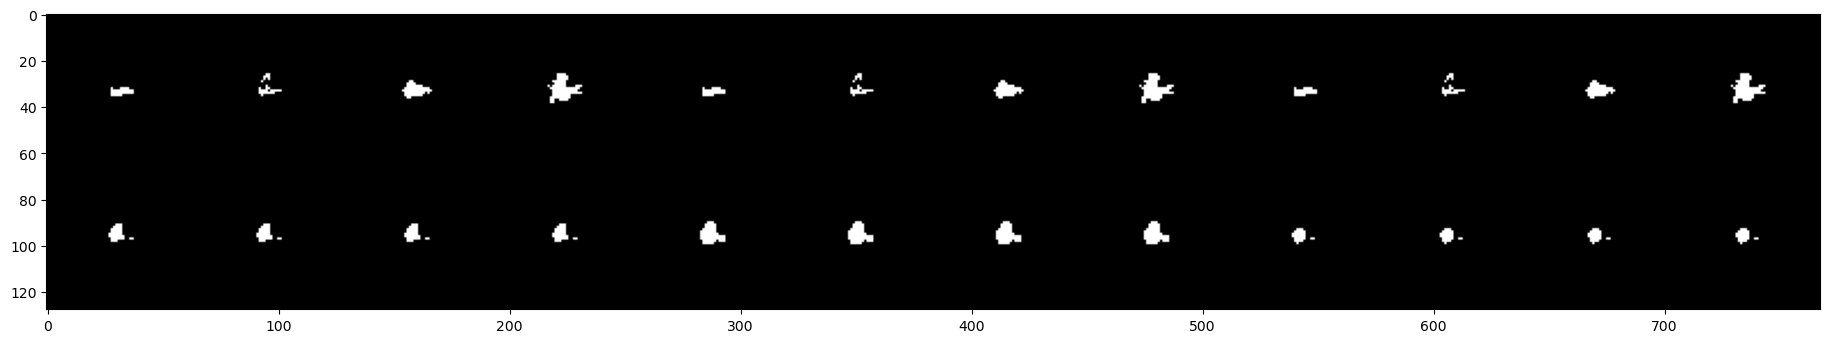

In [39]:
im = np.concatenate([gts,pred],axis=1)[None].transpose(2,1,3,4,0)
jlc.montage(im,figsize_per_pixel=0.03)

# gen tables

In [1]:
%load_ext autoreload
%autoreload 2

from source.utils.plot import collect_gen_table
import matplotlib.pyplot as plt
import numpy as np
import jlc
import pandas as pd

plot_metrics = ["CI","D_max","S_c","GED","iou"]

## Learning rate

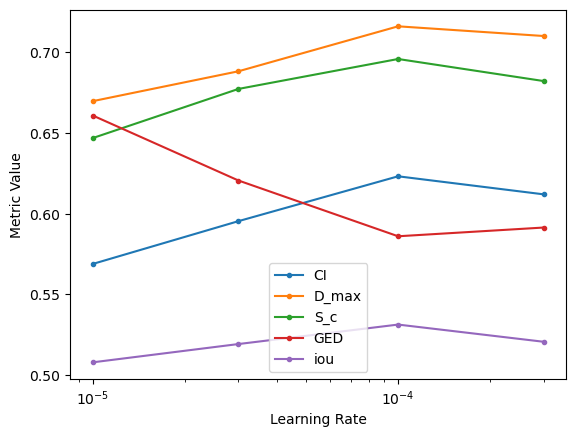

In [62]:
#learning rate sweep
table = collect_gen_table(gen_id_patterns="lr_sweep_lidc2*",record_from_args=["lr"],verbose=False)
plot_metrics = ["CI","D_max","S_c","GED","iou"]
x = [float(x) for x in table["lr"].values]
for m in plot_metrics:
    y = [float(x) for x in table[m].values]
    plt.plot(x,y,".-",label=m)
plt.legend()
plt.xscale("log")
plt.ylabel("Metric Value")
plt.xlabel("Learning Rate");

## number of channels

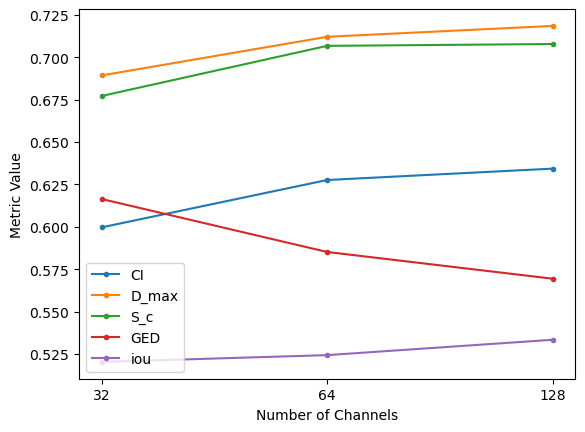

In [60]:
#num_channels sweep
table = collect_gen_table(gen_id_patterns="lr_sweep_lidc3*",record_from_args=["num_channels"],verbose=False)
x = [(x) for x in table["num_channels"].values]
for m in plot_metrics:
    y = [float(x) for x in table[m].values]
    plt.plot(x,y,".-",label=m)
plt.legend()
plt.ylabel("Metric Value")
plt.xlabel("Number of Channels");

## guidance weight sweep

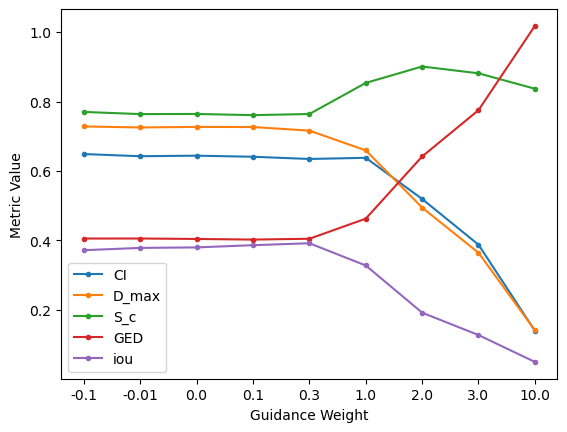

In [10]:
#guidance weight sweep
table = collect_gen_table(gen_id_patterns="lidc_gw_sweep2_*",
                        model_id_patterns="lidcv4",
                        record_from_sample_opts=["guidance_weight"],
                        include_mode="all",verbose=False)
only_upto = None
x = [x for x in table["guidance_weight"].values][:only_upto]
for m in plot_metrics:
    y = [float(x) for x in table[m].values][:only_upto]
    plt.plot(x,y,".-",label=m)
plt.legend()
plt.ylabel("Metric Value")
plt.xlabel("Guidance Weight");

## number of timesteps

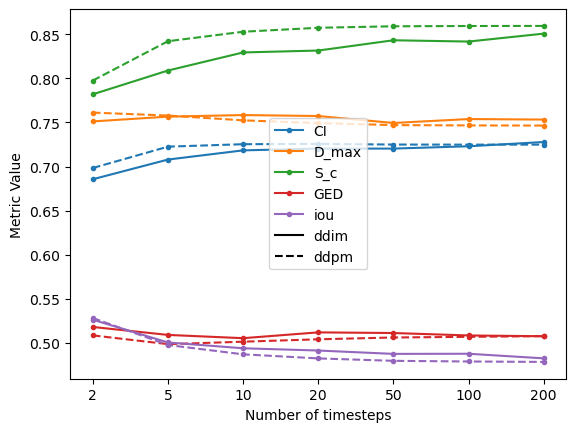

In [57]:
#timestep sweep
table_ddpm = collect_gen_table(gen_id_patterns="ts_sweep_*",
                        model_id_patterns="lidc[v3][b_sweep]_2*",
                        record_from_sample_opts=["num_timesteps"],
                        include_mode="all",verbose=False)
table_ddim = collect_gen_table(gen_id_patterns="ddim_sweep_*",
                        model_id_patterns="lidc[v3][b_sweep]_2*",
                        record_from_sample_opts=["num_timesteps"],
                        include_mode="all",verbose=False)
x_ddpm = [x for x in table_ddpm["num_timesteps"].values]
x_ddim = [x for x in table_ddim["num_timesteps"].values]
for i,m in enumerate(plot_metrics):

    y_ddpm = [float(x) for x in table_ddpm[m].values]
    y_ddim = [float(x) for x in table_ddim[m].values]
    plt.plot(x_ddpm,y_ddpm,".-",color=f"C{i}",label=m)
    plt.plot(x_ddim,y_ddim,".--",color=f"C{i}")
plt.plot(float("nan"),float("nan"),"-",label="ddim",color="black")
plt.plot(float("nan"),float("nan"),"--",label="ddpm",color="black")
plt.legend()
plt.ylabel("Metric Value")
plt.xlabel("Number of timesteps");

## input scale

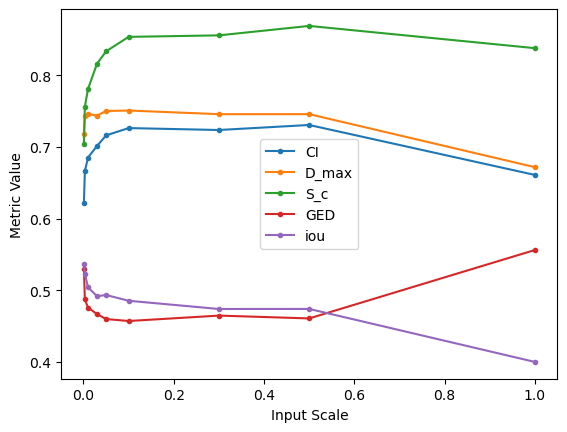

In [2]:
#input scale sweep
table = collect_gen_table(gen_id_patterns="lidc_b_sweep2_*",
                        model_id_patterns="lidc[v3][b_sweep]_*",
                        record_from_args=["input_scale"],
                        verbose=False)

x = table["input_scale"].values.astype(float)
order = np.argsort(x)
x = x[order]
for m in plot_metrics:
    y = np.array([float(x) for x in table[m].values])[order]
    plt.plot(x,y,".-",label=m)
plt.legend()
plt.ylabel("Metric Value")
plt.xlabel("Input Scale");

## >=2 model comparison

Matched pattern lidcv4 with model_id lidcv4
Matched pattern lidc_eval[ambopt][nosave]_1 with gen_id lidc_eval[ambopt][nosave]_1 from model_id lidcv4
Matched pattern lidc_eval[ambopt][nosave]_2 with gen_id lidc_eval[ambopt][nosave]_2 from model_id lidcv4
                   ari                       gen_id  \
0  0.43578505009096863  lidc_eval[ambopt][nosave]_1   
1  0.43253811642934864  lidc_eval[ambopt][nosave]_2   

                   gen_setup                hiou                 iou  \
0  lidc_eval[ambopt][nosave]  0.3828190506579383  0.3828190506579383   
1  lidc_eval[ambopt][nosave]  0.3798371259104505  0.3798371259104505   

              max_ari            max_hiou                  mi   step  \
0  0.9078139220425903  0.8633213472305025  0.3924127436668027  20000   
1  0.9075759733955662  0.8634451648719484   0.389475806730514  20000   

                   CI                 D_a               D_max  \
0  0.6460867096672729  0.9980095192232723  0.7252584622488957   
1  0.64400485492

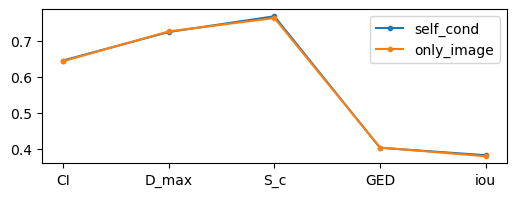

In [13]:
# comparisons of 2 or more models
comparison = "v4_self_cond"
if comparison=="self_cond":
    gen_id_list = ["lidc_eval[amb][nosave]_0","lidc_eval[amb][nosave]_2"]
    gen_id_names = ["self_cond","only_image"]
    model_id_patterns = "lidcv3_1"
elif comparison=="train_vs_vali":
    gen_id_list = ["actual_ged_3","actual_ged_1"]
    gen_id_names = ["train","vali"]
    model_id_patterns = "lidc[v2][lr_sweep]_3"
elif comparison=="gw_sweep":
    gen_id_list = ["lidc_eval[amb][nosave]_0","lidc_gw_sweep_0"]
    gen_id_names = ["self_cond","only_image"]
    model_id_patterns = "lidcv3_1"
elif comparison=="actual_ged":
    gen_id_list = ["actual_ged_1","actual_ged_2"]
    gen_id_names = ["new GED","old GED"]
    model_id_patterns = "lidc[v3][b_sweep]_2"
elif comparison=="v4_self_cond":
    gen_id_list = "lidc_eval[ambopt][nosave]_1,lidc_eval[ambopt][nosave]_2".split(",")
    gen_id_names = ["self_cond","only_image"]
    model_id_patterns = "lidcv4"
table = collect_gen_table(gen_id_patterns=gen_id_list,
                          model_id_patterns=model_id_patterns,
                          include_mode="all",
                          record_from_sample_opts="gen_id")
plt.figure(figsize=(6,2))
for gen_id,name in zip(gen_id_list,gen_id_names):
    idx = table["gen_id"]==gen_id
    y = [float(table[idx][m].item()) for m in plot_metrics]
    x = np.arange(len(y))
    plt.plot(x,y,".-",label=name)
plt.legend()
plt.xticks(x,plot_metrics);

# copy LIDC data to paper format

In [130]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
from source.utils.mixed import load_json_to_dict_list, ambiguous_info_from_fn
from source.utils.dataloading import load_raw_image_label
from PIL import Image
info_path = "/home/jloch/Desktop/diff/diffusion2/data/lidc/info.jsonl"

#params
image_size = 128
folder = Path("/home/jloch/Desktop/diff/Ambiguous-Medical-Image-Segmentation-using-Diffusion-Models/data2")
exactly_4 = True

split2folder = {0: "training", 1: "validation", 2: "testing"}
num_per_split = {k: 0 for k in split2folder.values()}
info = load_json_to_dict_list(info_path)
pri_didx = []
gts_didx = {}
for i,info_i in tqdm.tqdm(enumerate(info)):
    fn = info_i["fn"]
    amb_info = ambiguous_info_from_fn(fn)
    if amb_info["m_i"]==0:
        didx = f"lidc/{info_i['i']}"
        pri_didx.append(didx)
        image_ids = [ambiguous_info_from_fn(info_j["fn"])["image_id"] for info_j in info[i:i+amb_info["m_tot"]]]
        assert len(set(image_ids))==1, f"Found multiple image_ids, but expected only one for fn={fn}. image_ids: {image_ids}"
        gts_didx[didx] = [f"lidc/{info_j['i']}" for info_j in info[i:i+amb_info["m_tot"]]]
        image = load_raw_image_label(didx,longest_side_resize=image_size)[0][:,:,0]
        labels = []
        for gts_didx_i in gts_didx[didx]:
            label = load_raw_image_label(gts_didx_i,longest_side_resize=image_size)[1]
            labels.append(label)
        split = split2folder[info_i["split_idx"]]
        j = num_per_split[split]
        save_folder = folder/split/f"{j}"
        save_folder.mkdir(parents=True,exist_ok=True)
        Image.fromarray(image).save(save_folder/f"image_{j+1}.jpg")
        if exactly_4:
            if len(labels)>4:
                labels = labels[:4]
            if len(labels)<4:
                labels += [np.zeros_like(labels[0]) for _ in range(4-len(labels))]
        for label_i,label in enumerate(labels):
            Image.fromarray((label[:,:,0]*255).astype(np.uint8)).save(save_folder/f"label{label_i}_.jpg")
        num_per_split[split] = j+1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


45431it [00:47, 961.33it/s] 


In [126]:
print(num_per_split)

{'training': 12622, 'validation': 1631, 'testing': 1490}


In [123]:
save_folder/f"image_{j+1}.jpg"

PosixPath('/home/jloch/Desktop/diff/Ambiguous-Medical-Image-Segmentation-using-Diffusion-Models/data2/training/0/image_1.jpg')

In [119]:
(label*255).astype(np.uint8).shape

(128, 128, 1)

In [121]:
p = "/home/jloch/Desktop/diff/Ambiguous-Medical-Image-Segmentation-using-Diffusion-Models/data/testing/23/label0_.jpg"

np.array(Image.open(p)).shape

(128, 128)

'torch.Size([1, 1, 128, 128])'


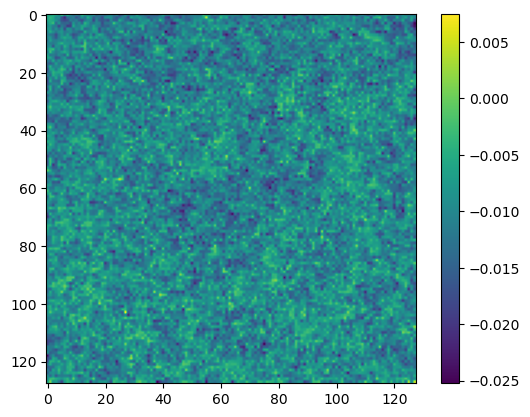

In [43]:
import torch
import jlc
import matplotlib.pyplot as plt 
p = "/home/jloch/Desktop/diff/Ambiguous-Medical-Image-Segmentation-using-Diffusion-Models/results/1173_output3"

item = torch.load(p,weights_only=False)
jlc.shaprint(item)

plt.imshow(item[0,0].cpu().detach().numpy())
plt.colorbar()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
p = "/home/jloch/Desktop/diff/Ambiguous-Medical-Image-Segmentation-using-Diffusion-Models/results/progress.csv"
columns = np.loadtxt(p,delimiter=",",max_rows=1,dtype=str).tolist()
data = np.loadtxt(p,delimiter=",",skiprows=1)
print(data.shape)
print(columns)


(200, 24)
['grad_norm', 'kl', 'kl_q0', 'kl_q1', 'kl_q2', 'kl_q3', 'loss', 'loss_q0', 'loss_q1', 'loss_q2', 'loss_q3', 'mse', 'mse_q0', 'mse_q1', 'mse_q2', 'mse_q3', 'param_norm', 'samples', 'step', 'vb', 'vb_q0', 'vb_q1', 'vb_q2', 'vb_q3']


Text(0.5, 0, 'Step')

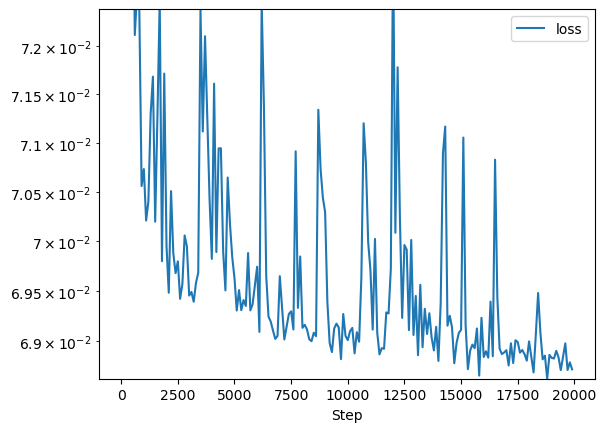

In [39]:
k = "loss"
x = data[:,columns.index("step")]
y = data[:,columns.index(k)]
plt.plot(x,y,label=k)
plt.yscale("log")
plt.ylim(y.min(),np.quantile(y,0.95))
plt.legend()
plt.xlabel("Step")

# LIDC from probablistic unet paper

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
filename = "./data/lidc/data_lidc.pickle"
data = np.load(filename,allow_pickle=True)
print(len(data))

15096


In [14]:
import jlc
jlc.shaprint(data[list(data.keys())[0]])

{'image': 'np.Size([128, 128])',
 'masks': ['np.Size([128, 128])',
           'np.Size([128, 128])',
           'np.Size([128, 128])',
           'np.Size([128, 128])'],
 'pixel_spacing': '<MultiValue>len2',
 'series_uid': '<UID>len64'}


In [15]:
masks_per_image = [len(data[k]["masks"]) for k in data.keys()]
print(np.unique(masks_per_image,return_counts=True))

(array([4]), array([2580]))


In [75]:
data = pickle.load(open("/home/jloch/Desktop/diff/diffusion2/data/lidc15096/data_lidc.pickle","rb"))
patient_ids = [k.split("_")[0] for k in data.keys()]
patient_ids = np.unique(patient_ids).tolist()
test_ratio = 0.1
vali_ratio = 0.1
np.random.seed(137)
np.random.shuffle(patient_ids)
i1,i2 = int(len(patient_ids)*test_ratio),int(len(patient_ids)*(test_ratio+vali_ratio))
test_ids = patient_ids[:i1]
vali_ids = patient_ids[i1:i2]
print(f"Found {len(patient_ids)} patients")
print(f"Found {len(test_ids)} test patients")
print(f"Found {len(vali_ids)} validation patients")
#save ids as txt
np.savetxt("/home/jloch/Desktop/diff/diffusion2/data/lidc15096/test_ids.txt",test_ids,fmt="%s")
np.savetxt("/home/jloch/Desktop/diff/diffusion2/data/lidc15096/vali_ids.txt",vali_ids,fmt="%s")

Found 875 patients
Found 87 test patients
Found 88 validation patients


In [76]:
image_splits = []
for k,v in data.items():
    patient_id = k.split("_")[0]
    if patient_id in test_ids:
        s = 2
    elif patient_id in vali_ids:
        s = 1
    else:
        s = 0
    image_splits.append(s)

"mask-i_3/4,slice-i_11/13,nodule-i_0/1,scan_1017,img_015741.dcm,mask_-00001.png"

print(np.unique(image_splits,return_counts=True))

(array([0, 1, 2]), array([11697,  1721,  1678]))


In [89]:
file_data = []
image_id = 0
for k,v in data.items():
    patient_id = patient_ids.index(k.split("_")[0])
    if "lesion" in k:
        n_i = int(k.split("lesion")[-1])-1
        tot_n = 2
    else:
        n_i = 0
        tot_n = 1
    rawslice = int(k.split("_")[-1].split("lesion")[0].replace("slice",""))
    for m_i in range(len(v["masks"])):
        file_data.append({"split_idx": 2 if patient_id in test_ids else (1 if patient_id in vali_ids else 0),
                        "m_i"        : m_i,
                        "s_i"        : None,
                        "n_i"        : n_i,

                        "tot_m"      : len(v["masks"]),
                        "tot_s"      : None,
                        "tot_n"      : tot_n,

                        "rawslice": rawslice,
                        "image_id"   : image_id,
                        "mask_id"    : m_i,
                        "patient_id" : patient_id})
    image_id += 1

# go through all the data and add slice indices for each unique patient,nodule pair
pair_to_slices = {} # (patient_id,n_i) -> {rawslice: [i1,i2,...]}
for i,f in enumerate(file_data):
    key = (f["patient_id"],f["n_i"])
    if not key in pair_to_slices:
        pair_to_slices[key] = {}
    pair_to_slices[key][f["rawslice"]] = [i] if not f["rawslice"] in pair_to_slices[key] else pair_to_slices[key][f["rawslice"]]+[i]
for k,v in pair_to_slices.items():
    tot_s = len(v)
    keys = list(v.keys())
    values = list(v.values())
    for s_i,indices in enumerate([values[i] for i in np.argsort(keys)]):
        for i in indices:
            file_data[i]["s_i"] = s_i
            file_data[i]["tot_s"] = tot_s

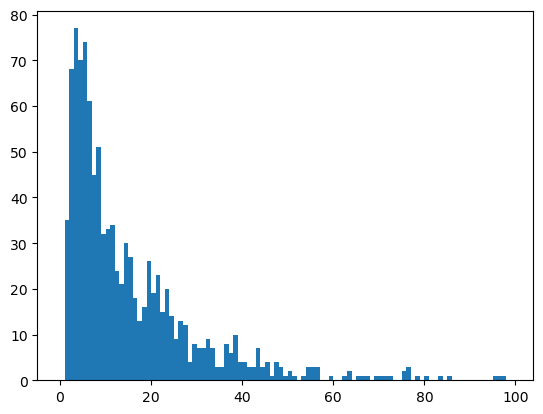

In [109]:
plt.hist([len(v) for v in pair_to_slices.values()],np.arange(100));

In [98]:
#print longest slices
i = np.argmax([len(v) for v in pair_to_slices.values()])
k = list(pair_to_slices.keys())[i]
v = pair_to_slices[k]
print(k)

(399, 0)


In [88]:
def fmt(f):
    return ",".join([
        f"mask-i_{f['m_i']}/{f['tot_m']}",
        f"slice-i_{f['s_i']}/{f['tot_s']}",
        f"nodule-i_{f['n_i']}/{f['tot_n']}",
        f"rawslice_{f['rawslice']}",
        f"img_{f['image_id']}",
        f"mask_{f['mask_id']}"
    ])
fmt(file_data[0])

'mask-i_0/4,slice-i_19/24,nodule-i_0/1,rawslice_20,img_0,mask_0'

In [103]:
p = "/home/jloch/Desktop/diff/diffusion2/data/lidc4/info.jsonl"
from source.utils.mixed import load_json_to_dict_list
loaded = load_json_to_dict_list(p)
print(len(loaded))

62972


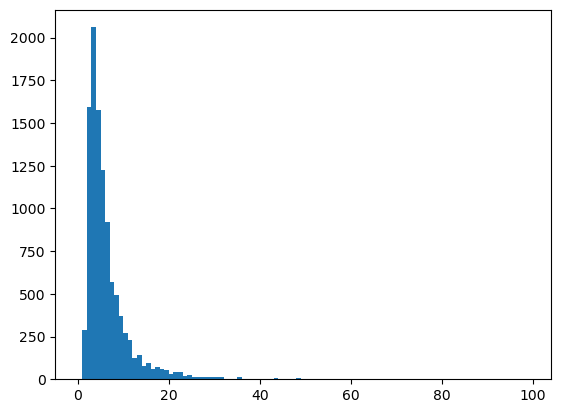

In [108]:
num_slices = []
for v in loaded:
    if "slice-i_0" in v["fn"]:
        num_slices.append(int(v["fn"].split("slice-i_0/")[1].split(",")[0]))
plt.hist(num_slices,bins=np.arange(100));

In [ ]:
config = {"z_dim": 6,
          "beta": None,
          "unet_mode": None,
          "dropout_rate": None,
}


In [139]:
import torch
save_dict = "/home/jloch/Desktop/diff/Probabilistic-Unet-Pytorch/saves/model_save.pth"
21999/23390], Loss: 213.4118:  94%|████████████████████████████████████████████████████████████████████▋    | 21999/23390 [06:43<00:25, 54.65it/s]{'elbo': '-213.4082', 'recon': '197.4076', 'kl': '1.6001', 'l2reg': '355.7598', 'iou': '0.1950'}
Epoch [10/10], Step [22999/23390], Loss: 199.5853:  98%|███████████████████████████████████████████████████████████████████████▊ | 22999/23390 [07:01<00:07, 55.33it/s]{'elbo': '-199.5818', 'recon': '184.8022', 'kl': '1.4780', 'l2reg': '355.7761', 'iou': '0.2966'}
Epoch [10/10], Step [23390/23390], Loss: 917.1651
loaded = torch.load(save_dict, weights_only=False)
print(loaded.keys())

dict_keys(['losses', 'step', 'net_state_dict'])


In [140]:
import jlc
jlc.num_of_params(loaded["net_state_dict"])

AttributeError: 'collections.OrderedDict' object has no attribute 'parameters'

In [135]:
loaded["step"]

27000

In [136]:
loaded["net_state_dict"] = loaded['./saves/net_state_dict']
del loaded['./saves/net_state_dict']

In [137]:
print(loaded.keys())

dict_keys(['losses', 'step', 'net_state_dict'])


In [138]:
torch.save(loaded,save_dict)

# Speedup metrics